10000
40
168
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1 112
 254 252 171 141  67  14   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  85 252 241  47   0   0   0   0   0   0 241 252
 252 252 250  75   0   0   0  74 254 198  10   0   0   0   0   0  46 126
 212 254 254 223   8   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


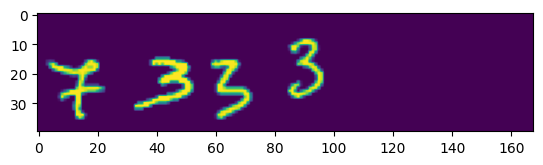

In [6]:
import numpy as np
import matplotlib.pyplot as plt


train_data1 = np.load('data0.npy')
train_lab1 = np.load('lab0.npy')
train_data2 = np.load('data1.npy')
train_lab2 = np.load('lab1.npy')
train_data3 = np.load('data2.npy')
train_lab3 = np.load('lab2.npy')

i = 1000
plt.imshow(train_data1[i])
plt.savefig('img.png')
print(len(train_data1))
print(len(train_data1[0]))
print(len(train_data1[0][0]))
print((train_data1[20][16]))

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.models as models


train_data1 = np.load('data0.npy')
train_lab1 = np.load('lab0.npy')
train_data2 = np.load('data1.npy')
train_lab2 = np.load('lab1.npy')
train_data3 = np.load('data2.npy')
train_lab3 = np.load('lab2.npy')

#Combine Data
train_data = np.concatenate([train_data1, train_data2, train_data3], axis=0)
train_labels = np.concatenate([train_lab1, train_lab2, train_lab3], axis=0)

#Normalize
train_data = train_data.astype(np.float32) / 255.0
train_labels = train_labels.astype(np.float32)

train_data = torch.tensor(train_data).unsqueeze(1)  
train_labels = torch.tensor(train_labels)

# 80-20 Split into Train and Val
dataset = TensorDataset(train_data, train_labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class DigitSumModel(nn.Module):
    def __init__(self):
        super(DigitSumModel, self).__init__()
        # Load a pre-trained ResNet and modify the input and output layers
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) 
        state_dict = models.resnet50(pretrained=True).state_dict()
        state_dict['conv1.weight'] = state_dict['conv1.weight'].sum(dim=1, keepdim=True) #Pre-trained weights adjusted by summing across the input channel dimension.
        self.resnet.load_state_dict(state_dict, strict=False)
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer


        # MLP to compute the sum of digits from extracted features
        self.mlp = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output single value for the sum
        )

    def forward(self, x):
        features = self.resnet(x)  # Extract features using ResNet
        output = self.mlp(features)  # Compute the sum using MLP
        return output

# Initialize the model, criterion, and optimizer
device = "cuda"
model = DigitSumModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.to(device)



DigitSumModel(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [12]:
num_epochs = 10
minl=100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device,torch.float32), targets.to(device,torch.float32)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device,torch.float32), targets.to(device,torch.float32)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    if train_loss + val_loss < minl:
        minl = train_loss + val_loss
        torch.save(model.state_dict(), "digit_sum_model.pth")

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/10, Train Loss: 0.0793, Val Loss: 0.4435
Epoch 2/10, Train Loss: 0.0381, Val Loss: 0.4297
Epoch 3/10, Train Loss: 0.0222, Val Loss: 0.5059
Epoch 4/10, Train Loss: 0.1455, Val Loss: 0.6557
Epoch 5/10, Train Loss: 0.1422, Val Loss: 0.5447
Epoch 6/10, Train Loss: 0.0824, Val Loss: 0.5016
Epoch 7/10, Train Loss: 0.0653, Val Loss: 0.5948
Epoch 8/10, Train Loss: 0.0492, Val Loss: 0.4940
Epoch 9/10, Train Loss: 0.0198, Val Loss: 0.3953
Epoch 10/10, Train Loss: 0.0219, Val Loss: 0.6085


C:\Users\madha\AppData\Local\Temp\ipykernel_27040\1312443109.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("digit_sum_model.pth"))


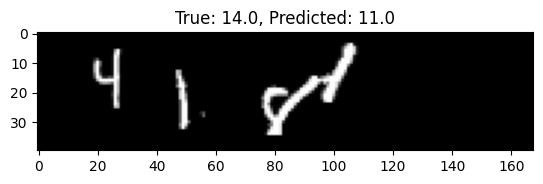

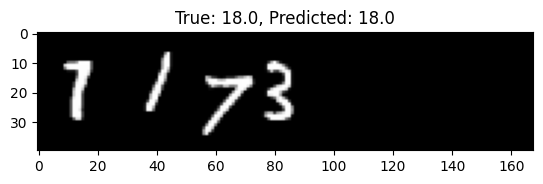

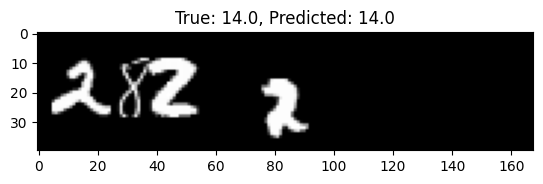

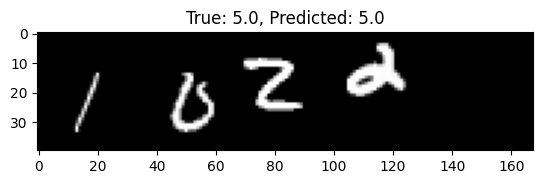

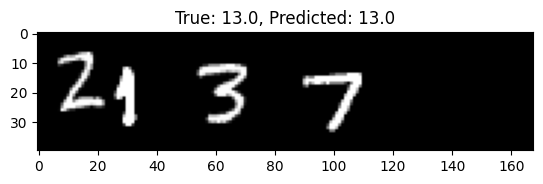

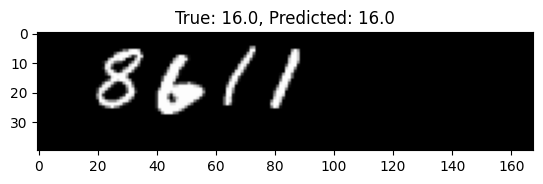

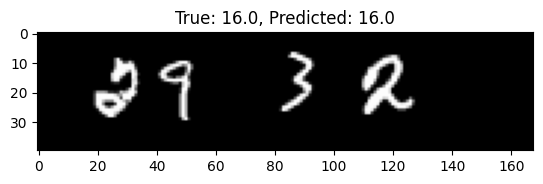

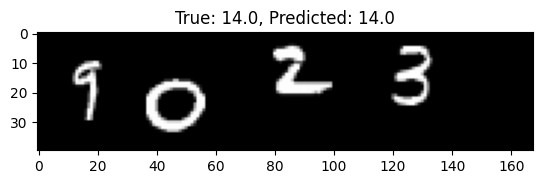

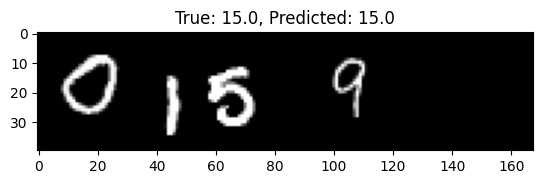

94.55

In [13]:
correct = 0
total=0
model.load_state_dict(torch.load("digit_sum_model.pth"))
model.eval()
model.to(device)
i=0
with torch.no_grad():
    for inputs, targets in val_loader:
        i+=1
        inputs, targets = inputs.to(device,torch.float32), targets.to(device,torch.float32)
        outputs = model(inputs).squeeze()
        outputs = torch.round(outputs)
        correct += (outputs == targets).sum().item()
        total += targets.size(0)
        if i % 10 == 0: 
            img = inputs[0].cpu().squeeze().numpy()  
            plt.imshow(img, cmap='gray')
            plt.title(f"True: {targets[0].item()}, Predicted: {outputs[0].item()}")
            plt.show()
    correct = 100 * correct/total
correct